In [1]:
# diagnosis_pipeline.ipynb (Python code format)

# ✅ Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Grad-CAM Utils
import cv2
from torch.autograd import Function

# ✅ Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data Transforms
transform_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Load Datasets
chest_train = datasets.ImageFolder("data/pneumonia/chest_xray/train", transform=transform_train)
chest_test = datasets.ImageFolder("data/pneumonia/chest_xray/test", transform=transform_test)

tumor_train = datasets.ImageFolder("data/tumor/train", transform=transform_train)
tumor_test = datasets.ImageFolder("data/tumor/test", transform=transform_test)

# ✅ DataLoaders
BATCH_SIZE = 32
chest_train_loader = DataLoader(chest_train, batch_size=BATCH_SIZE, shuffle=True)
chest_test_loader = DataLoader(chest_test, batch_size=BATCH_SIZE, shuffle=False)

tumor_train_loader = DataLoader(tumor_train, batch_size=BATCH_SIZE, shuffle=True)
tumor_test_loader = DataLoader(tumor_test, batch_size=BATCH_SIZE, shuffle=False)

# ✅ Define HighAccuracyCNN
class HighAccuracyCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(HighAccuracyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# ✅ Training and Evaluation Functions
def train_model(model, train_loader, test_loader, epochs=20):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        train_acc.append(acc)

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)
        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.2f}% - Test Acc: {test_acc[-1]:.2f}%")
    return train_acc, test_acc

# ✅ Plotting function
def plot_accuracy(train_acc, test_acc, title="Accuracy"):
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Evaluate Model
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Train on Pneumonia
print("\n--- Training on Chest X-ray (Pneumonia Detection) ---")
model_chest = HighAccuracyCNN()
acc_chest_train, acc_chest_test = train_model(model_chest, chest_train_loader, chest_test_loader)
plot_accuracy(acc_chest_train, acc_chest_test, title="Chest X-ray Accuracy")
evaluate_model(model_chest, chest_test_loader)

# ✅ Train on Brain Tumor
print("\n--- Training on Brain MRI (Tumor Detection) ---")
model_tumor = HighAccuracyCNN()
acc_tumor_train, acc_tumor_test = train_model(model_tumor, tumor_train_loader, tumor_test_loader)
plot_accuracy(acc_tumor_train, acc_tumor_test, title="Brain Tumor Accuracy")
evaluate_model(model_tumor, tumor_test_loader)

# ✅ Grad-CAM (optional: to be implemented separately or in Streamlit app)
# Grad-CAM functionality will be added in `app.py` for interactive predictions.

print("\n✅ Pipeline complete. Ready for Grad-CAM explainability in app.py")



--- Training on Chest X-ray (Pneumonia Detection) ---


KeyboardInterrupt: 

In [2]:
# ---------------new----------------------------------------------------------------------------------------
# 📌 Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns


# Grad-CAM tools
import cv2
import matplotlib.cm as cm


In [3]:
# 📌 Cell 2: Dataset Paths
pneumonia_train_dir = 'data/pneumonia/chest_xray/train'
pneumonia_val_dir   = 'data/pneumonia/chest_xray/val'
pneumonia_test_dir  = 'data/pneumonia/chest_xray/test'

tumor_train_dir = 'data/tumor/train'
tumor_test_dir  = 'data/tumor/test'


In [4]:
# 📌 Cell 3: Data Generators
def get_generators(train_dir, val_dir=None, test_dir=None, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True
    )

    valgen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train = datagen.flow_from_directory(train_dir, target_size=target_size, class_mode='binary', batch_size=32)
    val = valgen.flow_from_directory(val_dir, target_size=target_size, class_mode='binary', batch_size=32) if val_dir else None
    test = valgen.flow_from_directory(test_dir, target_size=target_size, class_mode='binary', batch_size=32, shuffle=False) if test_dir else None
    
    return train, val, test


In [5]:
# 📌 Cell 4: Build EfficientNetV2S (for Pneumonia)
def build_pneumonia_model():
    base = EfficientNetV2S(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')
    x = layers.Dropout(0.3)(base.output)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
# 📌 Cell 5: Train Pneumonia Model
p_train, p_val, p_test = get_generators(pneumonia_train_dir, pneumonia_val_dir, pneumonia_test_dir)
pneumonia_model = build_pneumonia_model()

# Add checkpoint to save best model
checkpoint_p = tf.keras.callbacks.ModelCheckpoint("models/best_pneumonia_model2.keras", save_best_only=True, monitor="val_accuracy", mode="max")
history = pneumonia_model.fit(p_train, epochs=10, validation_data=p_val, callbacks=[checkpoint_p])

# Save the final pneumonia model
os.makedirs("models", exist_ok=True)
pneumonia_model.save("models/pneumonia_model2.keras")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


c:\Users\dell\OneDrive\Documents\Medical Diagnosis\Medical diagnosis1\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1910s 11s/step - accuracy: 0.8918 - loss: 0.3053 - val_accuracy: 0.9375 - val_loss: 0.1522
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1658s 10s/step - accuracy: 0.9704 - loss: 0.0942 - val_accuracy: 0.8125 - val_loss: 0.3240
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1272s 8s/step - accuracy: 0.9786 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 0.0984
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1214s 7s/step - accuracy: 0.9843 - loss: 0.0496 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1202s 7s/step - accuracy: 0.9902 - loss: 0.0310 - val_accuracy: 0.9375 - val_loss: 0.0967
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1155s 7s/step - accuracy: 0.9861 - loss: 0.0403 - val_accuracy: 0.9375 - val_loss: 0.1105
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1033s 6s/step - accuracy: 0.9890 - loss: 0.0303 - val_accuracy: 1.0000 - val_loss: 0.0436
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1034s 6s/step - accuracy: 0.9896 - loss: 0.0226 

20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       234
           1       0.96      0.94      0.95       390

    accuracy                           0.94       624
   macro avg       0.93      0.94      0.93       624
weighted avg       0.94      0.94      0.94       624

Confusion Matrix:
 [[220  14]
 [ 25 365]]


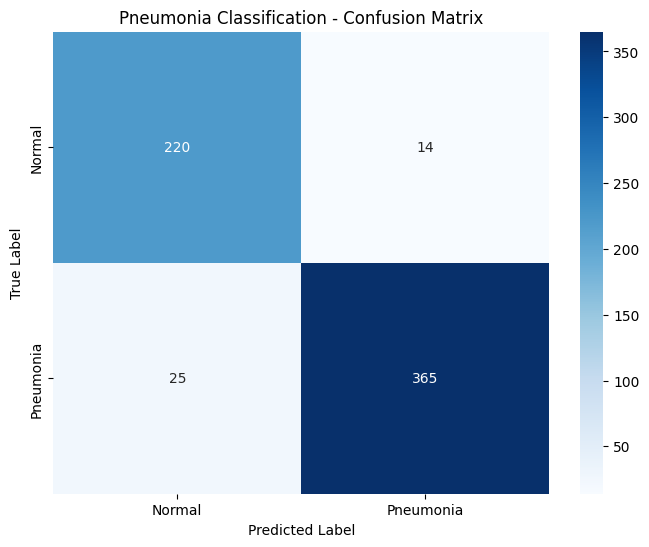

In [7]:
# # 📌 Cell 6: Evaluate Pneumonia Model
# preds = pneumonia_model.predict(p_test)
# y_pred = (preds > 0.5).astype(int)
# print("Classification Report:\n", classification_report(p_test.classes, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(p_test.classes, y_pred))

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 📌 Cell 6: Evaluate Pneumonia Model
preds = pneumonia_model.predict(p_test)
y_pred = (preds > 0.5).astype(int)

# Textual Evaluation
print("Classification Report:\n", classification_report(p_test.classes, y_pred))
print("Confusion Matrix:\n", confusion_matrix(p_test.classes, y_pred))

# 📊 Plot Confusion Matrix
cm = confusion_matrix(p_test.classes, y_pred)
class_names = ['Normal', 'Pneumonia']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Pneumonia Classification - Confusion Matrix')
plt.show()


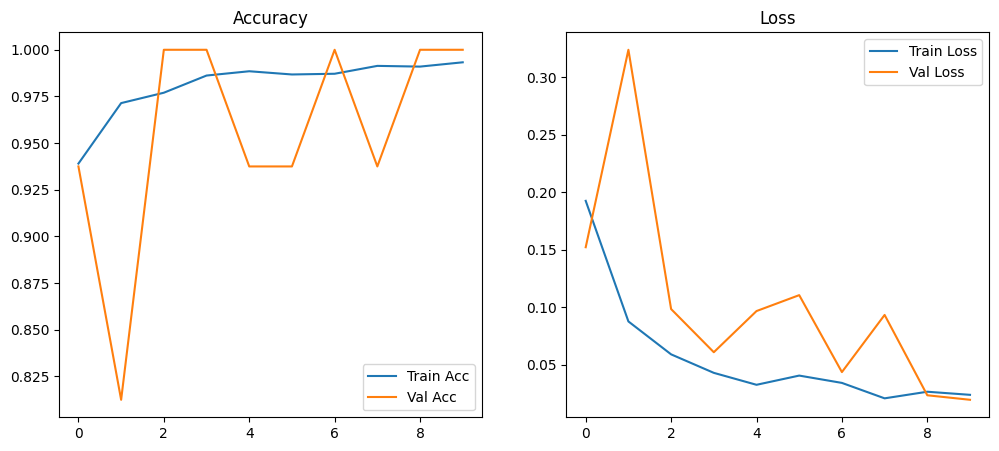

In [8]:
# 📌 Cell 7: Plot Training Curves
def plot_curves(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title("Loss")
    plt.show()

plot_curves(history)

In [13]:
# ✅ Cell : Load Models
pneumonia_model = tf.keras.models.load_model("models/pneumonia_model2.keras")
pneumonia_model._name = "pneumonia_model"

tumor_model = tf.keras.models.load_model("models/tumor_model2.keras")
tumor_model._name = "tumor_model"


In [14]:
# 📌 Cell 8: Grad-CAM for Explanation (Pneumonia)
# ✅ Cell : Load Models
pneumonia_model = tf.keras.models.load_model("models/pneumonia_model2.keras")
pneumonia_model._name = "pneumonia_model"

tumor_model = tf.keras.models.load_model("models/tumor_model2.keras")
tumor_model._name = "tumor_model"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        output = predictions[:, pred_index]

    grads = tape.gradient(output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, model_name="unknown", threshold=0.5):
    import os

    # Infer task type from image path
    if 'pneumonia' in img_path.lower():
        task = 'pneumonia'
    elif 'tumor' in img_path.lower():
        task = 'tumor'
    else:
        task = 'unknown'

    # Check if model matches image type
    if task not in model_name.lower():
        print(f"❌ Error: Model trained for '{model_name}' used on a '{task}' image.")
        print("👉 Please use the correct model for the given input image.")
        return

    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_exp = np.expand_dims(preprocess_input(img_array), axis=0)

    # Prediction
    pred = model.predict(img_array_exp)[0][0]

    # Grad-CAM Heatmap
    heatmap = make_gradcam_heatmap(img_array_exp, model)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original = tf.keras.preprocessing.image.img_to_array(img)
    superimposed_img = np.uint8(heatmap * 0.4 + original)

    # Label and Confidence
    if pred >= threshold:
        label_text = f"{task.capitalize()} Detected\nConfidence: {pred*100:.2f}%"
    else:
        label_text = f"No {task.capitalize()}\nConfidence: {(1 - pred)*100:.2f}%"

    # Extend canvas for label
    canvas = np.zeros((250, 224, 3), dtype=np.uint8)
    canvas[:224, :, :] = superimposed_img

    # Add text
    y0, dy = 230, 20
    for i, line in enumerate(label_text.split('\n')):
        cv2.putText(canvas, line, (5, y0 + i * dy),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.6, color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA)

    # Display
    plt.imshow(canvas.astype('uint8'))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()




# def display_gradcam(img_path, model):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = np.expand_dims(preprocess_input(img_array), axis=0)
#     heatmap = make_gradcam_heatmap(img_array, model)

#     heatmap = cv2.resize(heatmap, (224, 224))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     superimposed_img = heatmap * 0.4 + tf.keras.preprocessing.image.img_to_array(img)
#     plt.imshow(np.uint8(superimposed_img)); plt.axis('off'); plt.title("Grad-CAM")
#     plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


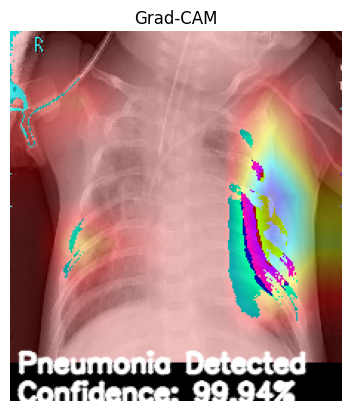

In [15]:
display_gradcam(
    'data/pneumonia/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg',
    pneumonia_model,
    model_name='pneumonia'
)


In [9]:
from tensorflow.keras.applications import EfficientNetV2S

def build_tumor_model():
    base = EfficientNetV2S(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg')
    x = layers.Dropout(0.3)(base.output)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [10]:
tumor_val_dir = 'data/tumor/val'
# Generate data
t_train, t_val, t_test = get_generators(tumor_train_dir, val_dir=tumor_val_dir, test_dir=tumor_test_dir)

# Build model
tumor_model = build_tumor_model()

# Save best model during training
checkpoint_t = tf.keras.callbacks.ModelCheckpoint(
    "models/best_tumor_model2.keras", save_best_only=True, monitor="val_accuracy", mode="max"
)

# Train the tumor model
history_t = tumor_model.fit(t_train, epochs=10, validation_data=t_val, callbacks=[checkpoint_t])

# Save final model
os.makedirs("models", exist_ok=True)
tumor_model.save("models/tumor_model2.keras")


Found 176 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


c:\Users\dell\OneDrive\Documents\Medical Diagnosis\Medical diagnosis1\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 169s 11s/step - accuracy: 0.6138 - loss: 0.6739 - val_accuracy: 0.5135 - val_loss: 0.7115
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.7596 - loss: 0.5257 - val_accuracy: 0.6757 - val_loss: 0.5402
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.9087 - loss: 0.3740 - val_accuracy: 0.7838 - val_loss: 0.4297
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - accuracy: 0.9131 - loss: 0.2773 - val_accuracy: 0.8919 - val_loss: 0.3287
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.8703 - loss: 0.2796 - val_accuracy: 0.9189 - val_loss: 0.1958
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 10s/step - accuracy: 0.9879 - loss: 0.1462 - val_accuracy: 0.9730 - val_loss: 0.1471
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.9883 - loss: 0.1237 - val_accuracy: 0.9730 - val_loss: 0.1342
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 9s/step - accuracy: 0.9627 - loss: 0.1377 - val_accuracy: 0.9459 - val_loss: 0.1243
Epoch

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.92      0.92      0.92        24

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

Confusion Matrix:
 [[14  2]
 [ 2 22]]


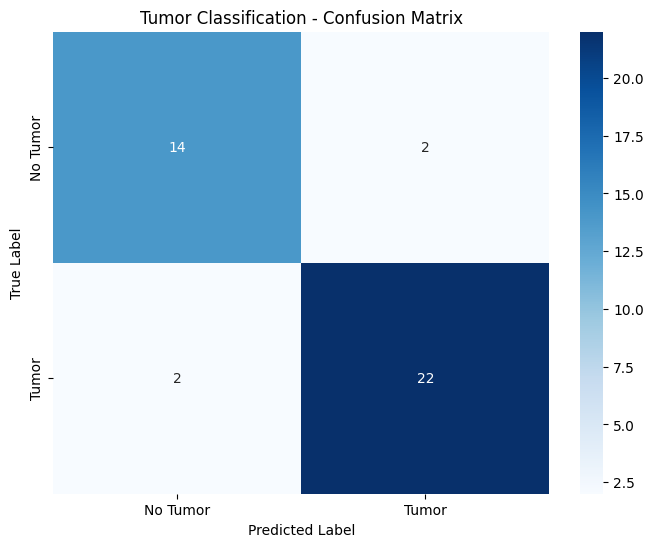

In [11]:
# # 📌 Cell 12: Evaluate Tumor Model
# preds = tumor_model.predict(t_test)
# y_pred = (preds > 0.5).astype(int)
# print("Tumor Classification Report:\n", classification_report(t_test.classes, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(t_test.classes, y_pred))

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 📌 Evaluate Tumor Model
preds = tumor_model.predict(t_test)
y_pred = (preds > 0.5).astype(int)

# Textual report
print("Classification Report:\n", classification_report(t_test.classes, y_pred))
print("Confusion Matrix:\n", confusion_matrix(t_test.classes, y_pred))

# 📊 Plot Confusion Matrix
cm = confusion_matrix(t_test.classes, y_pred)
class_names = ['No Tumor', 'Tumor']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tumor Classification - Confusion Matrix')
plt.show()




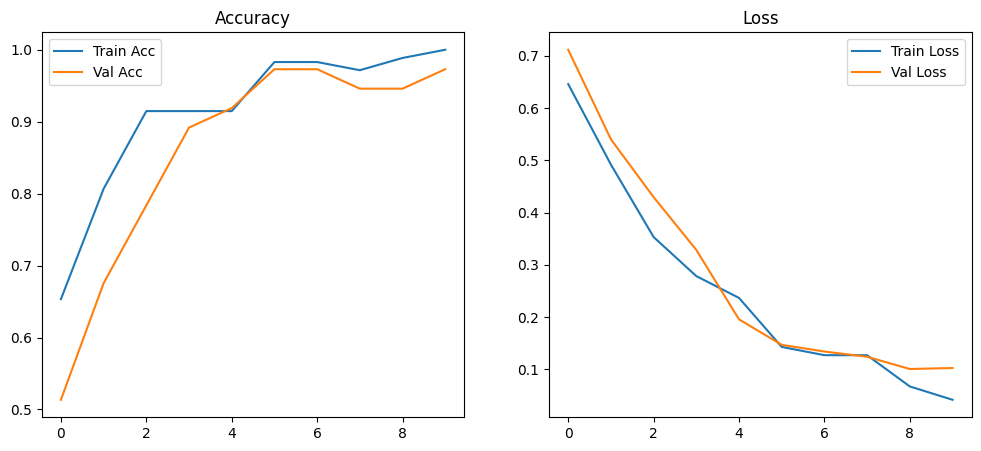

In [12]:
# 📊 Plot Training Curves for Tumor Model
def plot_curves(history_t):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history_t.history['accuracy'], label='Train Acc')
    plt.plot(history_t.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history_t.history['loss'], label='Train Loss')
    plt.plot(history_t.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_curves(history_t)  # ✅ Correct usage


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


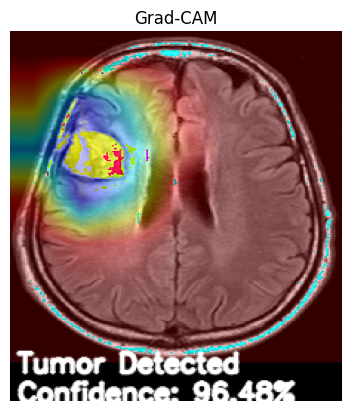

In [16]:
display_gradcam(
    'data/tumor/test/yes/Y7.JPG',
    tumor_model,
    model_name='tumor'
)